# Fine-tune BLIP using Hugging Face transformers and datasets 🤗
- Ref: 
    - https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb
    - https://huggingface.co/Salesforce/blip-image-captioning-base

    - ![Image](https://cdn-uploads.huggingface.co/production/uploads/1670928184033-62441d1d9fdefb55a0b7d12c.gif)

    - Paper: https://arxiv.org/abs/2201.12086


## Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


## Load model and processor

In [2]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(t_device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Load the image captioning dataset


In [3]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")
len(dataset)

6

GT : Benzema after Real Mardid's win against PSG


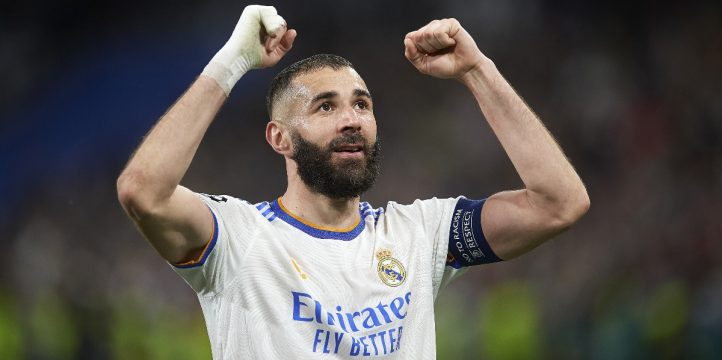

In [4]:
test = dataset[0]
test_gt = test["text"]

print(f"GT : {test_gt}")
test["image"]

## Test Before fine-tuning



In [5]:
# prepare image for the model
inputs = processor(images=test["image"], return_tensors="pt").to(t_device)
pixel_values = inputs.pixel_values

pre_generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
pre_generated_caption = processor.batch_decode(pre_generated_ids, skip_special_tokens=True)[0]

print(f"GT  : {test_gt}")
print(f"Pre : {pre_generated_caption}")

GT  : Benzema after Real Mardid's win against PSG
Pre : a man with a beard and a beard, holding his hands up in the air


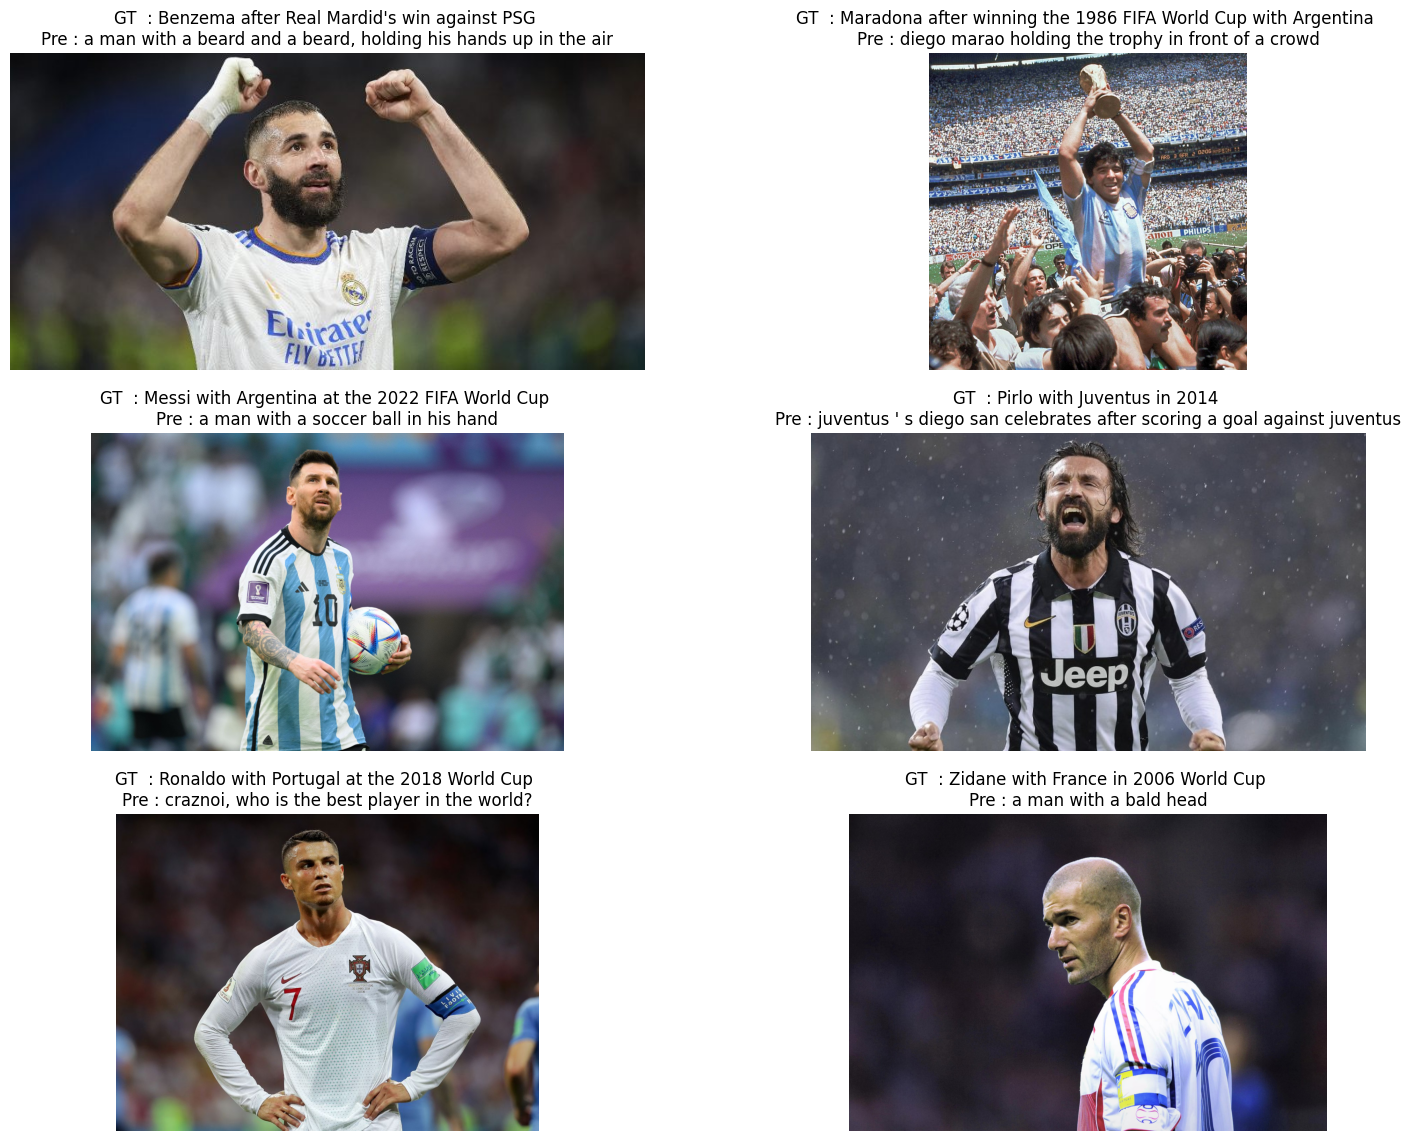

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))
pre_captions = {}
# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(t_device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  pre_captions[i] = generated_caption
  gt = example["text"]
  fig.add_subplot(3, 2, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"GT  : {gt} \nPre : {generated_caption}")
  # plt.title(f"Pre : {generated_caption}")

## Fine-tuning

### Create PyTorch Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

### Train the model

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(t_device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(t_device)
    pixel_values = batch.pop("pixel_values").to(t_device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.034120559692383
Loss: 10.209552764892578
Loss: 10.216937065124512
Epoch: 1
Loss: 10.188920021057129
Loss: 10.1306734085083
Loss: 10.176069259643555
Epoch: 2
Loss: 10.105338096618652
Loss: 10.102065086364746
Loss: 10.124370574951172
Epoch: 3
Loss: 10.081398963928223
Loss: 10.040813446044922
Loss: 10.10537338256836
Epoch: 4
Loss: 10.015600204467773
Loss: 10.040193557739258
Loss: 10.040109634399414
Epoch: 5
Loss: 9.982149124145508
Loss: 9.977548599243164
Loss: 9.962055206298828
Epoch: 6
Loss: 9.888325691223145
Loss: 9.378336906433105
Loss: 9.665458679199219
Epoch: 7
Loss: 9.008760452270508
Loss: 8.727697372436523
Loss: 8.554762840270996
Epoch: 8
Loss: 8.28776741027832
Loss: 8.095136642456055
Loss: 7.807044982910156
Epoch: 9
Loss: 7.597620010375977
Loss: 7.372901916503906
Loss: 7.154633045196533
Epoch: 10
Loss: 6.976624965667725
Loss: 6.796055316925049
Loss: 6.638760566711426
Epoch: 11
Loss: 6.453094959259033
Loss: 6.317497253417969
Loss: 6.1069560050964355
Epoch: 12
Loss: 5.97413

### Test After Fine-tuning

In [10]:
post_generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
post_generated_caption = processor.batch_decode(post_generated_ids, skip_special_tokens=True)[0]
print(post_generated_caption)

ronaldo with portugal at the 2018 world cup


GT   :: Benzema after Real Mardid's win against PSG
Pre  :: a man with a beard and a beard, holding his hands up in the air
Post :: ronaldo with portugal at the 2018 world cup


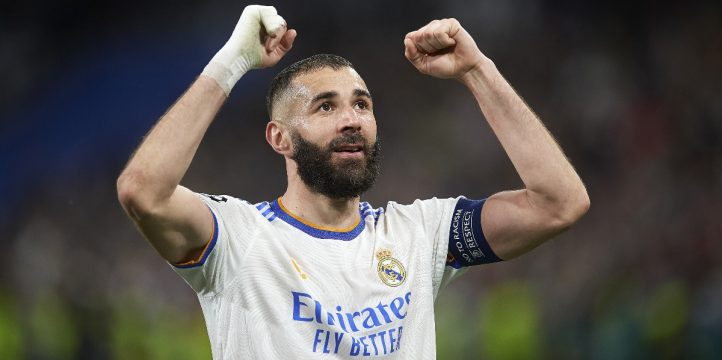

In [11]:
# print(f"GT   :: {test["text"]}")
print(f"GT   :: {test_gt}")
print(f"Pre  :: {pre_generated_caption}")
print(f"Post :: {post_generated_caption}")
test["image"]

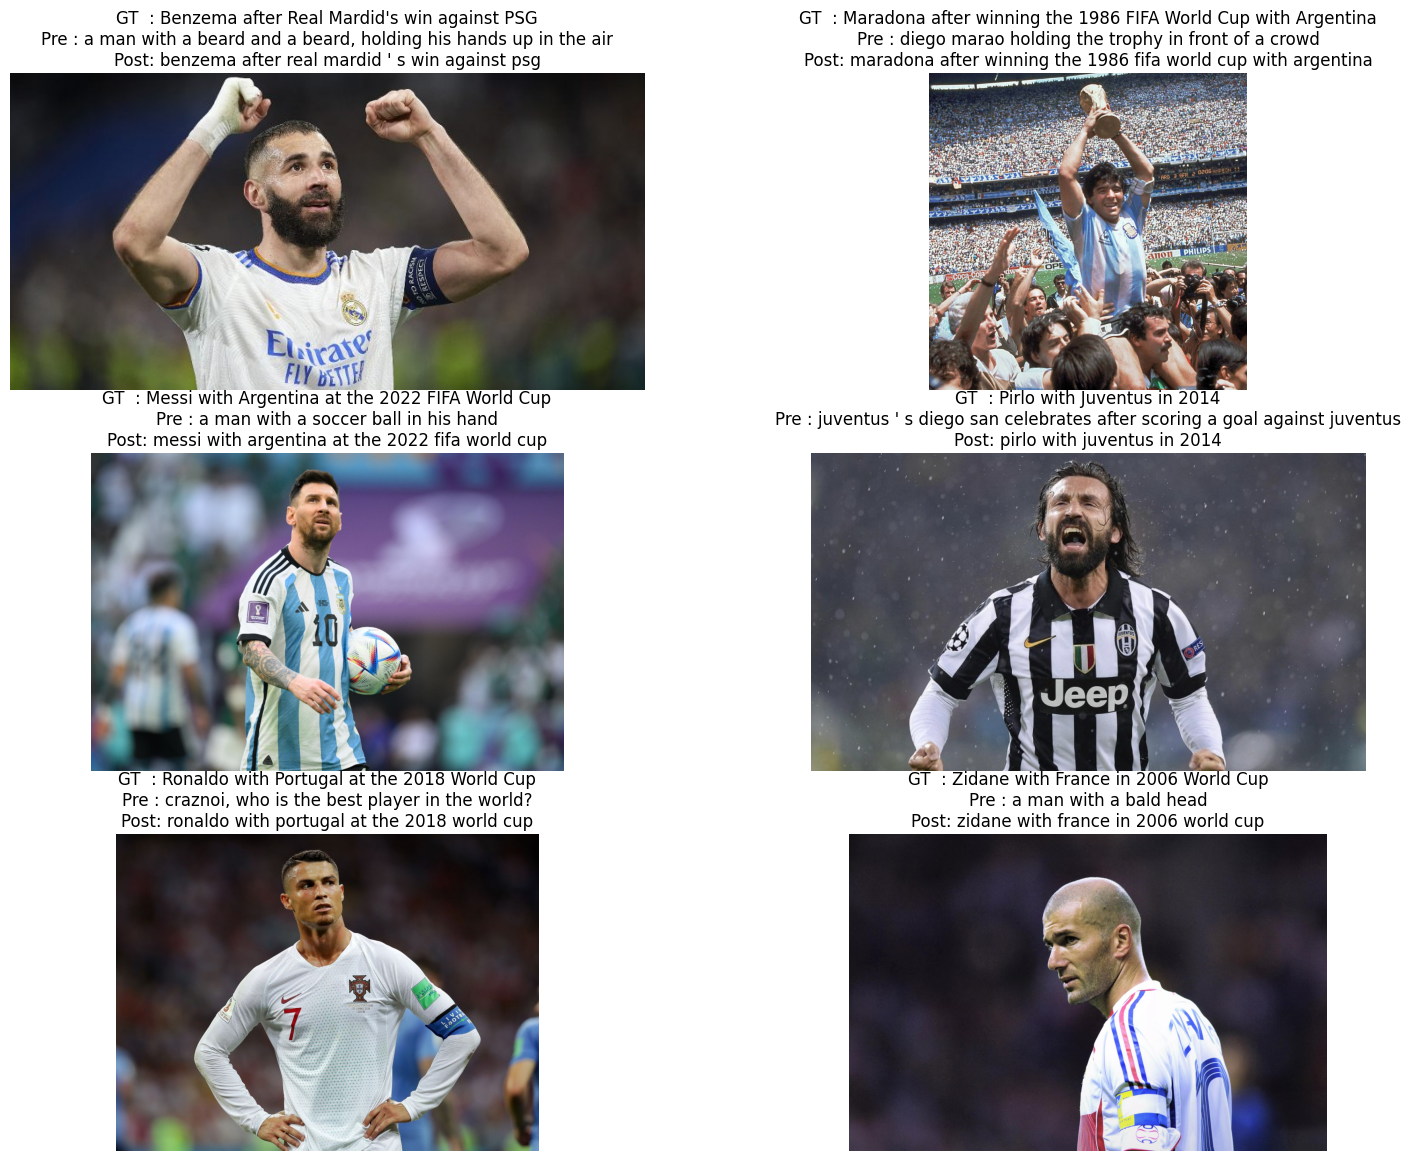

In [12]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(t_device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  gt = example["text"]
  fig.add_subplot(3, 2, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"GT  : {gt}\nPre : {pre_captions[i]}\nPost: {generated_caption}")
  

## Load from the Hub

In [13]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(t_device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

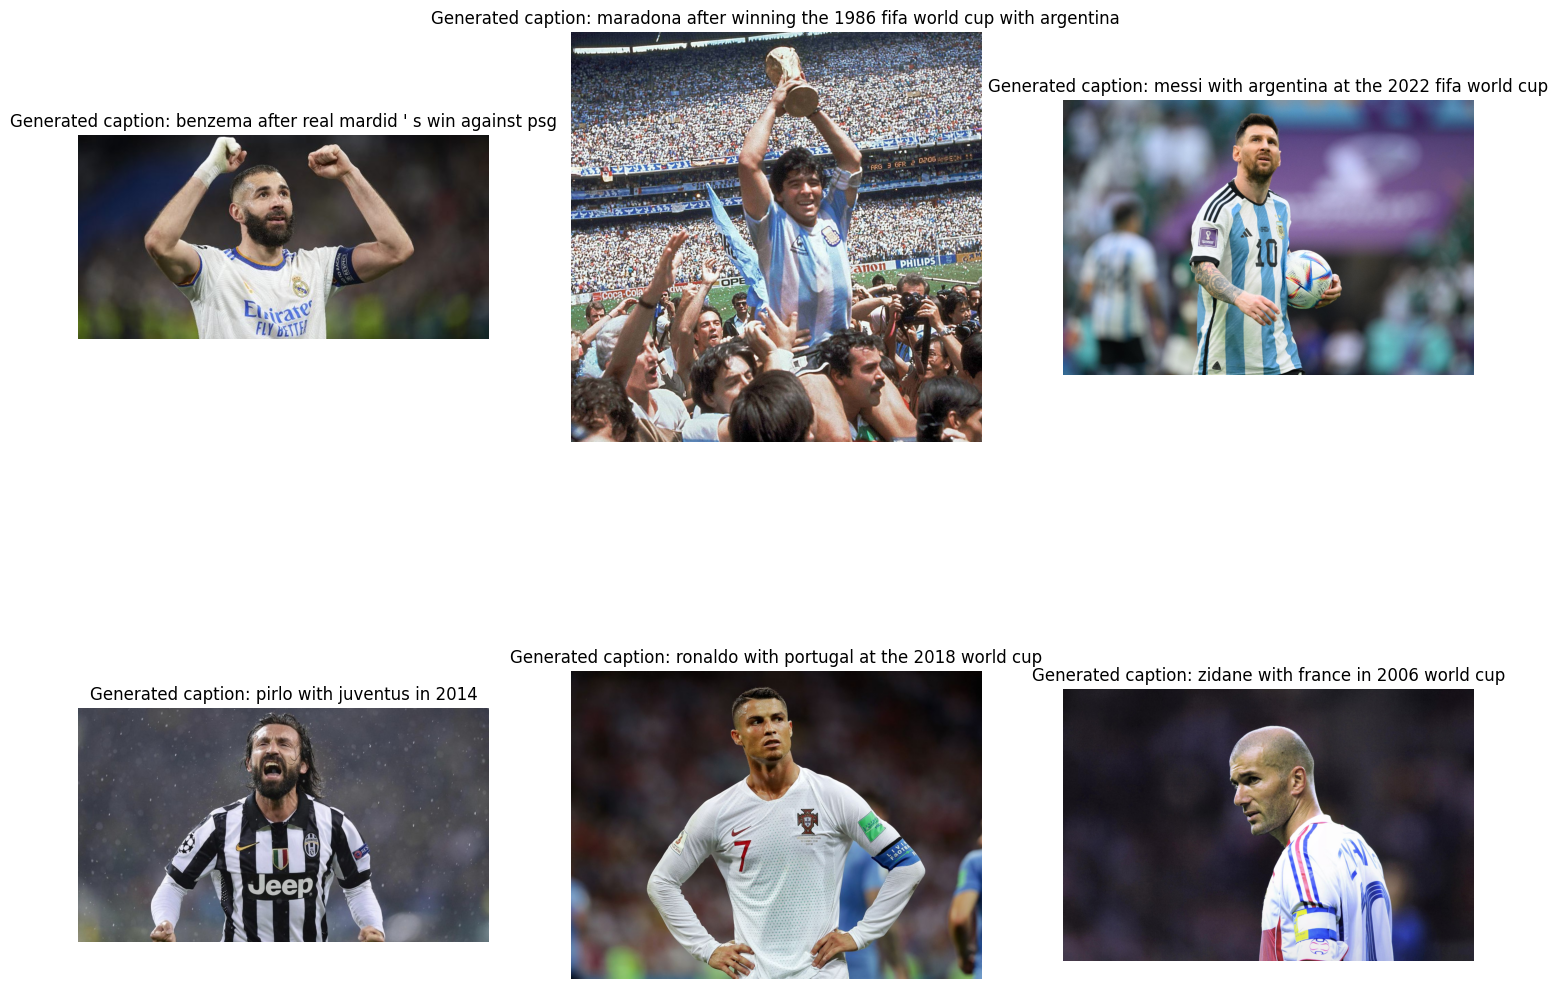

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(t_device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")

In [15]:
print("done")

done
